Import libraries

In [1]:
from numba import cuda 
device = cuda.get_current_device()
device.reset()

In [1]:
import tensorflow as tf
import tensorflow_io as tfio
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np
import os
from scipy.ndimage.morphology import distance_transform_edt


2025-03-07 10:41:08.800770: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-07 10:41:08.808438: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-03-07 10:41:08.817210: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-03-07 10:41:08.819689: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-07 10:41:08.826895: I tensorflow/core/platform/cpu_feature_guar

Set the input paths and parameters

In [2]:
train_input_path = "/home/khietdang/Documents/khiet/tiles/train/x"
train_mask_path = "/home/khietdang/Documents/khiet/tiles/train/y"
test_input_path = "/home/khietdang/Documents/khiet/tiles/test/x"
test_mask_path = "/home/khietdang/Documents/khiet/tiles/test/y"
model_path = "/home/khietdang/Documents/khiet/tree-ring-analyzer/src/models"

Get the paths of the images and masks

In [3]:
train_input_paths = [os.path.join(train_input_path, path) for path in os.listdir(train_input_path) if path.endswith(".tif")]
train_mask_paths = [os.path.join(train_mask_path, path) for path in os.listdir(train_mask_path) if path.endswith(".tif")]
print("Input images: " + str(len(train_input_paths)))
print("Input masks: " + str(len(train_mask_paths)))
print("---")
test_input_paths = [os.path.join(test_input_path, path) for path in os.listdir(test_input_path) if path.endswith(".tif")]
test_mask_paths = [os.path.join(test_mask_path, path) for path in os.listdir(test_mask_path) if path.endswith(".tif")]
print("Test images: " + str(len(test_input_paths)))
print("Test masks: " + str(len(test_mask_paths)))
train_path_dataset = tf.data.Dataset.from_tensor_slices((train_input_paths, train_mask_paths))
test_path_dataset = tf.data.Dataset.from_tensor_slices((test_input_paths, test_mask_paths))


Input images: 10358
Input masks: 10358
---
Test images: 2590
Test masks: 2590


I0000 00:00:1741340472.557966   52276 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1741340472.581242   52276 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1741340472.581359   52276 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1741340472.583746   52276 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

In [4]:
for pair in train_path_dataset.take(1):
    print(pair)

(<tf.Tensor: shape=(), dtype=string, numpy=b'/home/khietdang/Documents/khiet/tiles/train/x/4 E 2 t_8\xc2\xb5m_x50_r0009_c0023.tif'>, <tf.Tensor: shape=(), dtype=string, numpy=b'/home/khietdang/Documents/khiet/tiles/train/y/4 E 2 t_8\xc2\xb5m_x50_r0009_c0023.tif'>)


2025-03-07 10:41:14.769681: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


We define a function to read image/mask pairs.

In [21]:
def read_images(img_path, segmentation_mask_path):
    img_data = tf.io.read_file(img_path)
    img = tfio.experimental.image.decode_tiff(img_data)
    img = img[:, :, 0:3]
    segm_data = tf.io.read_file(segmentation_mask_path)
    segm_mask = tfio.experimental.image.decode_tiff(segm_data)
    segm_mask = segm_mask[:,:,0:1]
    
    return img, segm_mask

Normalize images and masks.

In [6]:
def prepare_images(img, semg_mask):
    # img = tfio.experimental.color.rgba_to_rgb(img)
    img = tf.image.convert_image_dtype(img, tf.float32)
    semg_mask = tf.image.convert_image_dtype(semg_mask, tf.float32)
    semg_mask = semg_mask / 255.0
    return img, semg_mask

We create a dataset containing pairs of images/masks.

In [7]:
train_dataset = train_path_dataset.map(read_images, num_parallel_calls=tf.data.AUTOTUNE).map(prepare_images, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = test_path_dataset.map(read_images, num_parallel_calls=tf.data.AUTOTUNE).map(prepare_images, num_parallel_calls=tf.data.AUTOTUNE)

2025-03-07 10:41:19.454975: I tensorflow_io/core/kernels/cpu_check.cc:128] Your CPU supports instructions that this TensorFlow IO binary was not compiled to use: SSE3 SSE4.1 SSE4.2 AVX AVX2 FMA


Trying to compensate for class imbalance.

Build train and validation batches.

In [8]:
BATCH_SIZE = 8
BUFFER_SIZE = 512
VALIDATION_SIZE = int(round((len(train_dataset) * 20) / 100))
print("validation data size: " + str(VALIDATION_SIZE))
print("train data size: " + str(len(train_dataset) - VALIDATION_SIZE))
validation_batches = train_dataset.take(VALIDATION_SIZE).batch(BATCH_SIZE)
train_batches = train_dataset.skip(VALIDATION_SIZE)
train_batches = train_dataset.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_batches = train_batches.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

validation data size: 2072
train data size: 8286


In [9]:
train_dataset.take(1)
print(type(train_dataset))

<class 'tensorflow.python.data.ops.map_op._ParallelMapDataset'>


In [10]:
data = train_dataset.take(1)
mask = data.get_single_element()[1]
mask

<tf.Tensor: shape=(256, 256, 1), dtype=float32, numpy=
array([[[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       ...,

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]]], dtype=float32)>

Display some random examples of pairs of input tiles and mask tiles.

(256, 256, 3)
(256, 256, 1)


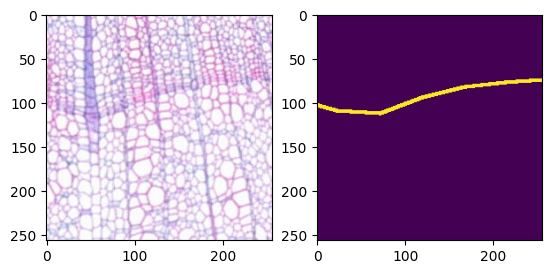

(256, 256, 3)
(256, 256, 1)


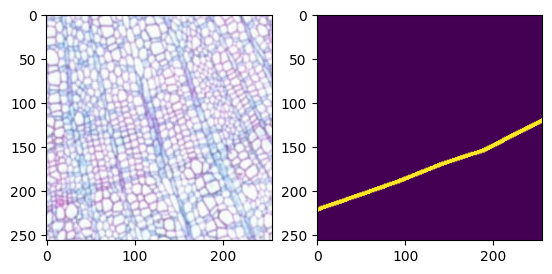

(256, 256, 3)
(256, 256, 1)


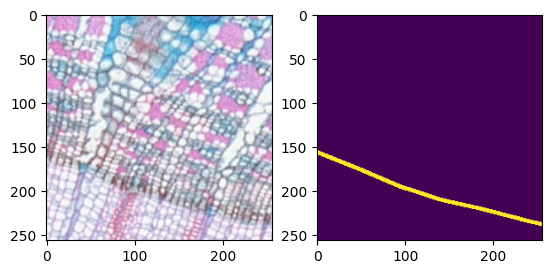

In [12]:
import matplotlib.pyplot as plt
N = 3
for image, mask in train_dataset.shuffle(len(train_dataset)).take(N):
    print(image.shape)
    print(mask.shape)
    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.imshow(image)
    ax2.imshow(mask[:, :, 0])
    plt.show()

Building blocks for the UNet.

In [13]:
def double_conv_block(x, n_filters):
   # Conv2D then ReLU activation
   x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
   # Conv2D then ReLU activation
   x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
   return x

def downsample_block(x, n_filters):
   f = double_conv_block(x, n_filters)
   p = layers.MaxPool2D(2)(f)
   p = layers.Dropout(0.3)(p)
   return f, p

def attention_gate(g, s, num_filters):
    Wg = layers.Conv2D(num_filters, 3, padding="same")(g)
    Wg = layers.BatchNormalization()(Wg)
 
    Ws = layers.Conv2D(num_filters, 3, padding="same")(s)
    Ws = layers.BatchNormalization()(Ws)
 
    out = layers.Activation("relu")(Wg + Ws)
    out = layers.Conv2D(num_filters, 3, padding="same")(out)
    out = layers.Activation("sigmoid")(out)
 
    return out * s
    
def upsample_block(x, conv_features, n_filters):
   # upsample
   x = layers.Conv2DTranspose(n_filters, 3, 2, padding="same")(x)
   s = attention_gate(x, conv_features, n_filters)
   # concatenate
   x = layers.concatenate([x, s])
   # dropout
   x = layers.Dropout(0.3)(x)
   # Conv2D twice with ReLU activation
   x = double_conv_block(x, n_filters)
   return x

Function that builds the UNet

In [14]:
def build_unet_model():
   inputs = layers.Input(shape=(256,256,3))
   # encoder: contracting path - downsample
   # 1 - downsample
   f1, p1 = downsample_block(inputs, 64)
   # 2 - downsample
   f2, p2 = downsample_block(p1, 128)

   # 3 - downsample
   f3, p3 = downsample_block(p2, 256)
   # 4 - downsample
   f4, p4 = downsample_block(p3, 512)
   # 5 - bottleneck
   bottleneck = double_conv_block(p4, 1024)
   # decoder: expanding path - upsample
   # 6 - upsample
   u6 = upsample_block(bottleneck, f4, 512)
   # 7 - upsample
   u7 = upsample_block(u6, f3, 256)
   # 8 - upsample
   u8 = upsample_block(u7, f2, 128)
   # 9 - upsample
   u9 = upsample_block(u8, f1, 64)
   # outputs
   outputs = layers.Conv2D(1, (1,1), padding="same", activation = "sigmoid")(u9)
   # unet model with Keras Functional API
   unet_model = tf.keras.Model(inputs, outputs, name="U-Net")
   return unet_model   

Build the UNet.

In [15]:
unet_model = build_unet_model()

Alternatively build the unet from the predifined keras models.

In [ ]:
from keras_unet_collection import models
unet_model = models.unet_2d((None, None, 3), [64, 128, 256, 512, 1024], n_labels=2,
                      stack_num_down=2, stack_num_up=1,
                      activation='GELU', output_activation='Softmax', 
                      batch_norm=True, pool='max', unpool='nearest', name='unet')

Define a loss function that is a weighted sum of dice and binary cross entropy.

In [16]:
@tf.keras.utils.register_keras_serializable()
def dice_loss(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    intersection = tf.reduce_sum(y_true * y_pred)
    return 1 - (2. * intersection + 1) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + 1)

@tf.keras.utils.register_keras_serializable()
def bce_dice_loss(bce_coef=0.5):
    @tf.keras.utils.register_keras_serializable()
    def bcl(y_true, y_pred):
        bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
        dice = dice_loss(y_true, y_pred)
        return bce_coef * bce + (1.0 - bce_coef) * dice
    return bcl

Create an image of the UNet architecture.

In [17]:
keras.utils.plot_model(unet_model, show_shapes=True)
"model.png written"

'model.png written'

Compile the model.

In [18]:
unet_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss=bce_dice_loss(bce_coef=0.3),
                  metrics=[tf.keras.metrics.Precision(),
                           tf.keras.metrics.Recall(),
                           tf.keras.metrics.Accuracy()])

Train the model.

In [19]:
NUM_EPOCHS = 100
keras.config.disable_traceback_filtering()
STEPS_PER_EPOCH = len(train_dataset) // BATCH_SIZE
VAL_SUBSPLITS = 5
VAL_LENGTH = VALIDATION_SIZE
VALIDATION_STEPS = VAL_LENGTH // BATCH_SIZE // VAL_SUBSPLITS
model_history = unet_model.fit(train_batches,
                              epochs=NUM_EPOCHS,
                              steps_per_epoch=STEPS_PER_EPOCH,
                              validation_steps=VALIDATION_STEPS,
                              validation_data=validation_batches, 
                              verbose=2
                              )

Epoch 1/100


I0000 00:00:1741340648.290726   52393 service.cc:146] XLA service 0x768ca80f0500 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1741340648.290742   52393 service.cc:154]   StreamExecutor device (0): NVIDIA RTX 4000 Ada Generation Laptop GPU, Compute Capability 8.9
2025-03-07 10:44:08.442305: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-03-07 10:44:09.067479: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8900
2025-03-07 10:44:10.688975: W external/local_tsl/tsl/framework/bfc_allocator.cc:291] Allocator (GPU_0_bfc) ran out of memory trying to allocate 17.17GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-03-07 10:44:11.236126: W external/local_tsl/tsl/framework/bfc_a

1294/1294 - 336s - 260ms/step - accuracy: 0.0063 - loss: 0.6778 - precision: 0.0156 - recall: 7.5840e-05 - val_accuracy: 0.0000e+00 - val_loss: 0.6780 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/100


2025-03-07 10:49:42.814724: W external/local_tsl/tsl/framework/bfc_allocator.cc:291] Allocator (GPU_0_bfc) ran out of memory trying to allocate 17.15GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-03-07 10:49:42.814751: W external/local_tsl/tsl/framework/bfc_allocator.cc:291] Allocator (GPU_0_bfc) ran out of memory trying to allocate 8.64GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-03-07 10:49:43.160343: W external/local_tsl/tsl/framework/bfc_allocator.cc:291] Allocator (GPU_0_bfc) ran out of memory trying to allocate 16.66GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-03-07 10:49:43.552130: W external/local_tsl/tsl/framework/bf

1294/1294 - 327s - 253ms/step - accuracy: 0.0000e+00 - loss: 0.6774 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.6780 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/100
1294/1294 - 307s - 237ms/step - accuracy: 0.0000e+00 - loss: 0.6774 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.6780 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/100
1294/1294 - 308s - 238ms/step - accuracy: 0.0000e+00 - loss: 0.6773 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.6780 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/100
1294/1294 - 307s - 238ms/step - accuracy: 0.0000e+00 - loss: 0.6773 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.6780 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 6/100
1294/1294 - 307s - 237ms/step - accuracy: 0.0000e+00 - loss: 0.6774 - precision: 0.0000e+00 - recall: 0.

KeyboardInterrupt: 

Save a model.

In [27]:
import datetime
date = datetime.datetime.now()
unet_model.save(os.path.join(model_path, str(date) + ".keras"))

Save the weights only.

In [28]:
import datetime
date = datetime.datetime.now()
unet_model.save_weights(os.path.join(model_path,  str(date) + ".weights.h5"))

In [ ]:
print(model_history.history.keys())

In [26]:
# summarize history for accuracy
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

NameError: name 'model_history' is not defined

Load a saved model

In [24]:
model = "2025-03-06 14:41:24.068815.keras"
path = os.path.join(model_path, model)
unet_model = keras.models.load_model(path)

Load the weights only.

In [25]:
model = '2025-03-06 14:41:50.401830.weights.h5'
path = os.path.join(model_path, model)
unet_model.load_weights(path)

Evaluate model on test data.

In [ ]:
test_batches = train_dataset.take(len(test_dataset)).batch(BATCH_SIZE)
score = unet_model.evaluate(test_batches, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

# Apply the model to an image.

Functions to read and prepare single images.

In [22]:
def read_image(img_path):
    img_data = tf.io.read_file(img_path)
    img = tfio.experimental.image.decode_tiff(img_data)
    img = img[:,:,0:3]
    return img

def prepare_image(img):   
    img = tf.image.convert_image_dtype(img, "float32") # This also scales to [O,1)
    return img


Create a dataset with patches of one image.

In [23]:
import tensorflow_io as tfio
import matplotlib.pyplot as plt
import cv2

image_file = '/home/khietdang/Documents/khiet/treeRing/input/4 E 1 m_8µm_x50.tif'
output_file = '/home/khietdang/Documents/khiet/treeRing/masks/4 E 1 m_8µm_x50.tif'
image_path_dataset = tf.data.Dataset.from_tensor_slices([image_file])
image_dataset = image_path_dataset.map(read_image, num_parallel_calls=tf.data.AUTOTUNE).map(prepare_image, num_parallel_calls=tf.data.AUTOTUNE)



ksize_rows = 256
ksize_cols = 256
strides_rows = 196
strides_cols = 196


# image = ds # tfio.experimental.image.decode_tiff(image_data)

# print(image)
# The size of sliding window
ksizes = [1, ksize_rows, ksize_cols, 1] 

# How far the centers of 2 consecutive patches are in the image
strides = [1, strides_rows, strides_cols, 1]

# The document is unclear. However, an intuitive example posted on StackOverflow illustrate its behaviour clearly. 
# http://stackoverflow.com/questions/40731433/understanding-tf-extract-image-patches-for-extracting-patches-from-an-image
rates = [1, 1, 1, 1] # sample pixel consecutively

# padding algorithm to used
padding='SAME' # or 'SAME'

# image = tf.expand_dims(image, 0)
image_patches = tf.image.extract_patches(images=list(image_dataset.take(1)), sizes=ksizes, strides=strides, rates=rates, padding=padding)


2025-03-07 14:11:07.343442: W tensorflow/core/framework/op_kernel.cc:1840] OP_REQUIRES failed at whole_file_read_ops.cc:116 : NOT_FOUND: /home/khietdang/Documents/khiet/treeRing/input/4 E 1 m_8µm_x50.tif; No such file or directory
2025-03-07 14:11:07.343549: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: NOT_FOUND: Error in user-defined function passed to ParallelMapDatasetV2:28 transformation with iterator: Iterator::Root::Prefetch::FiniteTake::ParallelMapV2::ParallelMapV2: /home/khietdang/Documents/khiet/treeRing/input/4 E 1 m_8µm_x50.tif; No such file or directory
	 [[{{node ReadFile}}]]


NotFoundError: {{function_node __wrapped__IteratorGetNext_output_types_1_device_/job:localhost/replica:0/task:0/device:CPU:0}} Error in user-defined function passed to ParallelMapDatasetV2:28 transformation with iterator: Iterator::Root::Prefetch::FiniteTake::ParallelMapV2::ParallelMapV2: /home/khietdang/Documents/khiet/treeRing/input/4 E 1 m_8µm_x50.tif; No such file or directory
	 [[{{node ReadFile}}]] [Op:IteratorGetNext] name: 

Display the input patches.

In [ ]:
columns = image_patches.shape[1]
rows = image_patches.shape[2]

print(columns, rows)
# retrieve the 1st patches
fig = plt.figure(figsize=(columns, rows)) 
fig.tight_layout()
i = 1
for col in range(columns):
    for row in range(rows):
        patch = image_patches[0,col,row,]
        patch = tf.reshape(patch, [ksize_rows, ksize_cols, 3])        
        fig.add_subplot(columns, rows, i) 
        plt.axis('off') 
        plt.imshow(patch)
        i = i + 1
# visualize image

plt.show()

Predict the rings on the patches

In [ ]:
columns = image_patches.shape[1]
rows = image_patches.shape[2]

print(columns, rows)
# retrieve the 1st patches
fig = plt.figure(figsize=(columns, rows)) 
fig.tight_layout()
i = 1
results = []
for col in range(columns):
    for row in range(rows):
        patch = image_patches[0,col,row,]
        patch = tf.reshape(patch, [1, ksize_rows, ksize_cols, 3])        
        res = unet_model.predict([patch], verbose=0)
        res = np.squeeze(res)
        results.append(res)
        fig.add_subplot(columns, rows, i) 
        plt.axis('off') 
        strides_rows
        i = i + 1

In [ ]:
plt.figure(figsize=(columns, rows)) 
output = np.array(results).reshape(columns, rows, ksize_cols, ksize_rows)
img = output[11][16]
img = (img > 0.000005).astype('uint8')
plt.imshow(img)
print(img)

Batch apply classifier

Set the input and output folders and the parameters.

In [ ]:
INPUT_FOLDER = "/media/baecker/6b38a953-6650-4da5-94d9-57bd718df733/2025/in/2007_tree_rings/input_images/input/"
OUTPUT_FOLDER = "/media/baecker/6b38a953-6650-4da5-94d9-57bd718df733/2025/in/2007_tree_rings/input_images/out/"
PATCH_SIZE = 256
STRIDE_WIDTH = 256
CHANNELS = 3
PADDING = 'VALID'
THRESHOLD = 0.000005

In [ ]:
import cv2
output = np.array(results).reshape(columns, rows, ksize_cols, ksize_rows)
height = list(image_dataset.take(1))[0].shape[0]
width = list(image_dataset.take(1))[0].shape[1] 
reconstructed = np.zeros(height*width).reshape(height, width)
print("image shape", reconstructed.shape)
y = 0
i = 0
for col in range(columns):
    x = 0
    for row in range(rows):   
        print("row: ", row, " col: ", col)
        yEnd = min(y+ksize_rows, height)
        xEnd = min(x+ksize_cols, width)
        deltaY = yEnd - y 
        deltaX = xEnd - x 
        reconstructed[y:yEnd, x:xEnd] = output[col, row, 0:deltaY, 0:deltaX]
        x = x + strides_cols 
    y = y + strides_rows
reconstructed = ((reconstructed > 0.000005).astype('uint8'))*255
reconstructed = np.roll(reconstructed, -(width % strides_cols), axis=0)
reconstructed = np.roll(reconstructed, -(height % strides_rows), axis=1)
cv2.imwrite(output_file, reconstructed)

Function to create patches, predict result patches from input patches and reconstruct a result image.

In [ ]:
def createPatches(image_file, patch_size=255, stride_width=196, padding='SAME'):
    image_path_dataset = tf.data.Dataset.from_tensor_slices([image_file])
    image_dataset = image_path_dataset.map(read_image, num_parallel_calls=tf.data.AUTOTUNE).map(prepare_image, num_parallel_calls=tf.data.AUTOTUNE)
    height = list(image_dataset.take(1))[0].shape[0]
    width = list(image_dataset.take(1))[0].shape[1] 
    ksizes = [1, patch_size, patch_size, 1] 
    strides = [1, stride_width, stride_width, 1]
    rates = [1, 1, 1, 1]
    patches = tf.image.extract_patches(images=list(image_dataset.take(1)), sizes=ksizes, strides=strides, rates=rates, padding=padding)
    return patches, height, width

def predictPatches(model, image_patches, patch_size=256, channels=3):
    columns = image_patches.shape[1]
    rows = image_patches.shape[2]
    results = []
    for col in range(columns):
        for row in range(rows):
            patch = image_patches[0,col,row,]
            patch = tf.reshape(patch, [1, patch_size, patch_size, channels])        
            res = model.predict([patch], verbose=0)
            res = np.squeeze(res)
            results.append(res)
    output = np.array(results).reshape(columns, rows, patch_size, patch_size)            
    return output

def reconstructFromPatches(patches, original_image_height, original_image_width, patch_size=256, stride_width=196, threshold=0.000005):
    height, width = original_image_height, original_image_width
    rows = patches.shape[1]
    columns = patches.shape[0]
    reconstructed = np.zeros(height*width).reshape(height, width)    
    y = 0
    for col in range(columns):
        x = 0
        for row in range(rows):   
            yEnd = min(y+patch_size, height)
            xEnd = min(x+patch_size, width)
            deltaY = yEnd - y 
            deltaX = xEnd - x
            reconstructed[y:yEnd, x:xEnd] = patches[col, row, 0:deltaY, 0:deltaX]
            x = x + stride_width 
        y = y + stride_width
    reconstructed = ((reconstructed > threshold).astype('uint8')) * 255
    return reconstructed


def displayPatches(patches, patch_size=256, channels=3):
    if tf.is_tensor(patches):
        columns = patches.shape[1]
        rows = patches.shape[2]
    else:
        columns = patches.shape[0]
        rows = patches.shape[1]
    fig = plt.figure(figsize=(columns, rows)) 
    fig.tight_layout()
    i = 1
    for col in range(columns):
        for row in range(rows):
            if tf.is_tensor(patches):
                patch = patches[0, col, row,]
                patch = tf.reshape(patch, [patch_size, patch_size, channels])        
            else:
                patch = patches[col, row]
            fig.add_subplot(columns, rows, i) 
            plt.axis('off') 
            plt.imshow(patch)
            i = i + 1
    plt.show()

In [ ]:
import cv2

def predictImage(image_file, model, patch_size=256, stride_width=196, padding="SAME", channels=3, threshold= 0.000005):
    imagePatches, height, width = createPatches(image_file, patch_size, stride_width, padding)
    maskPatches = predictPatches(model, imagePatches, patch_size, channels)
    mask = reconstructFromPatches(maskPatches, height, width, patch_size, stride_width, threshold)
    return mask

def batchPredict(input_folder, output_folder, patch_size=256, stride_width=196, padding="SAME", channels=3, threshold= 0.000005):
    predict_input_paths = [os.path.join(input_folder, path) for path in os.listdir(input_folder) if path.endswith(".tif")]
    predict_output_paths = [os.path.join(output_folder, path) for path in os.listdir(input_folder) if path.endswith(".tif")]
    paths = zip(predict_input_paths, predict_output_paths)
    counter = 1
    for input_file, output_file in paths:
        print("Processing image " + str(counter) + " of " + str(len(predict_input_paths)))
        print("in: ", input_file)
        print("out: ", output_file)
        mask = predictImage(input_file, unet_model, patch_size, stride_width, padding, channels, threshold)
        cv2.imwrite(output_file, mask)
        counter = counter + 1

Test create patches

In [ ]:
IMAGE_PATH = "/home/khietdang/Documents/khiet/treeRing/input/T 5 b_8µm_x50.tif"
imagePatches, height, width = createPatches(IMAGE_PATH, PATCH_SIZE, STRIDE_WIDTH, PADDING)
print(height, width)
displayPatches(imagePatches, PATCH_SIZE, CHANNELS)

Test predict patches.

In [ ]:
output = predictPatches(unet_model, imagePatches, PATCH_SIZE, CHANNELS)

In [ ]:
print(output.shape)

In [ ]:
displayPatches(output, PATCH_SIZE, CHANNELS)

Test reconstruct from patches.

In [ ]:
reconstructed = reconstructFromPatches(output, height, width, PATCH_SIZE, STRIDE_WIDTH, THRESHOLD)
plt.figure(figsize=(8, 8)) 
plt.axis('off') 
plt.imshow(reconstructed)

Test predict image

In [ ]:
mask = predictImage('/home/khietdang/Documents/khiet/treeRing/input/4 E 1 b_8µm_x50.tif', unet_model, 256, 256, "VALID", 3, 0.000005)
plt.figure(figsize=(8, 8)) 
plt.axis('off') 
plt.imshow(mask)

In [ ]:
print(type(output), output.shape, tf.is_tensor(output))
print(type(imagePatches), imagePatches.shape, tf.is_tensor(imagePatches))

Batch segment the images in a folder

In [ ]:
batchPredict('/media/bae/media/baecker/6b38a953-6650-4da5-94d9-57bd718df733/2025/in/2007_tree_rings/input_images/train/mask/cker/6b38a953-6650-4da5-94d9-57bd718df733/2025/in/2007_tree_rings/unused', '/media/baecker/6b38a953-6650-4da5-94d9-57bd718df733/2025/in/2007_tree_rings/unused/out', PATCH_SIZE, STRIDE_WIDTH, PADDING, CHANNELS, THRESHOLD)

Calculate the ratio of background and foreground pixel in the ground truth.

In [ ]:
FOLDER = "/media/baecker/6b38a953-6650-4da5-94d9-57bd718df733/2025/in/2007_tree_rings/input_images/test/mask/"
input_paths = [os.path.join(FOLDER, path) for path in os.listdir(FOLDER) if path.endswith(".tif")]
total = 256 * 256 * len(input_paths)
positive = 0
for input_file in input_paths:
    img = read_image(input_file)
    channel = img[0:,0:,1]
    pos = channel[channel>0]
    number_positive_pixels = len(pos)
    positive = positive + number_positive_pixels
print(total / positive)
print(positive / total)

In [ ]:
img = read_image("/media/baecker/6b38a953-6650-4da5-94d9-57bd718df733/2025/in/2007_tree_rings/input_images/train/mask/T 5 t_8µm_x50_r0024_c0014.tif")
channel = img[0:,0:,1]
print(channel.shape)
plt.figure(figsize=(8, 8)) 
plt.axis('off') 
plt.imshow(channel)
pos = channel[channel>0]
print(len(pos))